# Replicating Ott et al. models

**Disclaimer: This notebook is not critical to understand state abstraction but was used by the author (Alex Lepauvre) to learn model fitting with PYMC and can be ignored!**

Following the approach described by Ott and colleagues (2022) <a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1), we will use bayesian modelling to test whether (or which level of) state abstraction is used by participants to perform our task. We will fit the decision values obtained under each state abstraction model and use Bayesian model comparison to identify the model that fits the data the closest. But since this is the first time I'm using pymc, I will start by replicating their results to make sure I wrapped my mind around how that works.  

In their paper, they fitted three different types of models:
- Planning strategy model
- Simple strategy model
- Hybrid strategy model

Each of these model has the following form:

$$p(accept) = \frac{1}{1+e^{-\eta}}$$

For simplicity, we will stick to the Hybrid strategy model, where $\eta$ is defined as such:

$$\eta = \beta DV + \theta_{1} I_{1} + \theta_{2} I_{2} + \theta_{3} I_{3} + \theta_{4} I_{4} + \theta_{maxE} I_{maxE} + \theta_{minE\_LC} I_{minE\_LC} + \theta_{minE\_HC} I_{minE\_HC}$$

Where the DV come from the dynamic programming model. Each \theta_{i} correspond to parameters associated with each offer for basic trials. This model therefore takes into account the fact that participants plan might be a mixture between the optimal policy (or some approximation thereof) and offer specific behaviour (participants might for example have positive $\theta_{3}$ and $\theta_{4}$ values and negative $\theta_{1}$ and $\theta_{2}$ parameters, reflecting the fact that participants are biased to accept good offers and reject low ones, regardless of the actual optimal plan). 

Let's try to replicate that on their publicly available data:


C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_39052\638000722.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if i > 10 and row[0] == 0:


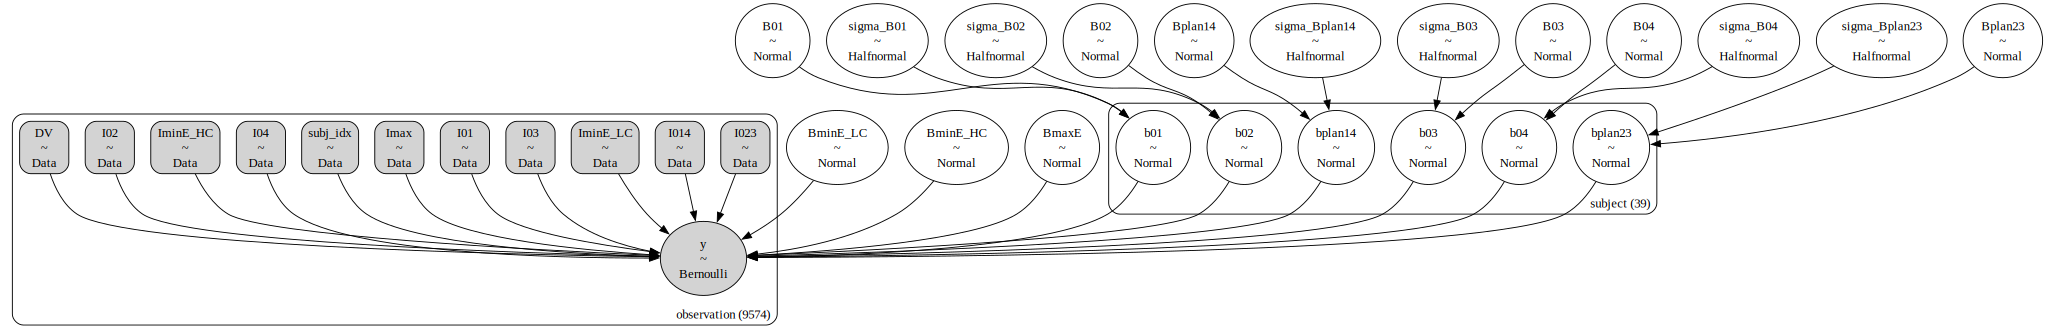

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit
import pymc as pm
import arviz as az
# initialize numpy rng seed:
rng = np.random.default_rng(12345)
# az.style.use("arviz-doc")
import matplotlib.pyplot as plt

# Download data from Florian's repo:
url = 'https://github.com/fmott/context_dependent_planning/blob/1.2/data/behaviour/data_all_participants_20220215120148.csv?raw=true'
data = pd.read_csv(url, on_bad_lines='skip')
# Remove nans:
data = data.dropna()
# Flip responses: 1 = accept:
data["response"] = np.abs(data["response"] - 1)
# Add a subject column:
sub_id = 1
for i, row in data.iterrows():
    if i > 10 and row[0] == 0:
        sub_id += 1
    data.at[i, 'subject'] = f'sub-{sub_id}'

# Get subject IDs:
subj_idx_raw, subj_labels = pd.factorize(data["subject"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}

data["IO23"] = data["is_2"] + data["is_3"]
data["IO14"] = data["is_1"] + data["is_4"]

with pm.Model(coords=coords) as binomial_regression_model:
    # Extract regressors:
    dv = pm.Data("DV", data["dv_planning"], dims="observation")  # Continuous: Decision value from dynamic programming model
    subj_idx = pm.Data("subj_idx", subj_idx_raw, dims="observation")  # Categorical: Subject index for random effect
    i_023 = pm.Data("I023", data["IO23"], dims="observation")  # Binary: Is first offer
    i_014 = pm.Data("I014", data["IO14"], dims="observation")  # Binary: Is second offe
    i_01 = pm.Data("I01", data["is_1"], dims="observation")  # Binary: Is first offer
    i_02 = pm.Data("I02", data["is_2"], dims="observation")  # Binary: Is second offer
    i_03 = pm.Data("I03", data["is_3"], dims="observation")  # Binary: Is third offer
    i_04 = pm.Data("I04", data["is_4"], dims="observation")  # Binary: Is fourth offer
    i_maxe = pm.Data("Imax", data["is_full_energy"], dims="observation")  # Binary: Special case of max energy
    i_mine_lc = pm.Data("IminE_LC", data["is_low_energy_LC"], dims="observation")  # Binary: Special case of energy too low to accept offer when cost is low
    i_mine_hc = pm.Data("IminE_HC", data["is_low_energy_HC"], dims="observation")  # Binary: Special case of energy too low to accept offer when cost is high

    # Hyperpriors (i.e. priors on fixed effects)
    # Parameters with random effects within subject:
    Bplan23 = pm.Normal('Bplan23', mu=0, sigma=2)  # Beta for decision values
    sigma_Bplan23 = pm.HalfNormal('sigma_Bplan23', sigma=2)  # Variance of Bplan across participants
    Bplan14 = pm.Normal('Bplan14', mu=0, sigma=2)  # Beta for decision values
    sigma_Bplan14 = pm.HalfNormal('sigma_Bplan14', sigma=2)  # Variance of Bplan across participants
    B01 = pm.Normal('B01', mu=0, sigma=2)  # Beta for bias associated with offer 1
    sigma_B01 = pm.HalfNormal('sigma_B01', sigma=2)  # Variance of B01 across participants
    B02 = pm.Normal('B02', mu=0, sigma=2)  # Beta for bias associated with offer 2
    sigma_B02 = pm.HalfNormal('sigma_B02', sigma=2)  # Variance of B02 across participants
    B03 = pm.Normal('B03', mu=0, sigma=2)  # Beta for bias associated with offer 3
    sigma_B03 = pm.HalfNormal('sigma_B03', sigma=2)   # Variance of B03 across participants
    B04 = pm.Normal('B04', mu=0, sigma=2)  # Beta for bias associated with offer 4
    sigma_B04 = pm.HalfNormal('sigma_B04', sigma=2)  # Variance of B04 across participants
    BmaxE = pm.Normal('BmaxE', mu=0, sigma=2)  # Beta for bias in max energy trials (no random effect across participants)
    BminE_LC = pm.Normal('BminE_LC', mu=0, sigma=2)  # Beta for bias in too low energy trials (no random effect across participants)
    BminE_HC = pm.Normal('BminE_HC', mu=0, sigma=2)  # Beta for bias in too low energy trials (no random effect across participants)
    
    # Within subject effects:
    bplan23 = pm.Normal('bplan23', mu=Bplan23, sigma=sigma_Bplan23, dims="subject")  # Beta for decision value for each specific subject
    bplan14 = pm.Normal('bplan14', mu=Bplan14, sigma=sigma_Bplan14, dims="subject")  # Beta for decision value for each specific subject
    b01 = pm.Normal('b01', mu=B01, sigma=sigma_B01, dims="subject")  # Beta for offer 1 trial for each specific subject
    b02 = pm.Normal('b02', mu=B02, sigma=sigma_B02, dims="subject")  # Beta for offer 2 trial for each specific subject
    b03 = pm.Normal('b03', mu=B03, sigma=sigma_B03, dims="subject")  # Beta for offer 3 trial for each specific subject
    b04 = pm.Normal('b04', mu=B04, sigma=sigma_B04, dims="subject")  # Beta for offer 4 trial for each specific subject
    
    # Expected value (i.e. statistical model)
    mu = bplan23[subj_idx] * dv * i_023 + bplan14[subj_idx] * dv * i_014 + b01[subj_idx] * i_01 + b02[subj_idx] * i_02 + b03[subj_idx] * i_03 + b04[subj_idx] * i_04 + BmaxE * i_maxe + BminE_LC * i_mine_lc + BminE_HC * i_mine_hc
    pm.Bernoulli("y", logit_p=mu, observed=data["response"], dims="observation")

pm.model_to_graphviz(binomial_regression_model)

c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bplan23, sigma_Bplan23, Bplan14, sigma_Bplan14, B01, sigma_B01, B02, sigma_B02, B03, sigma_B03, B04, sigma_B04, BmaxE, BminE_LC, BminE_HC, bplan23, bplan14, b01, b02, b03, b04]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 101 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\arviz\plots\traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


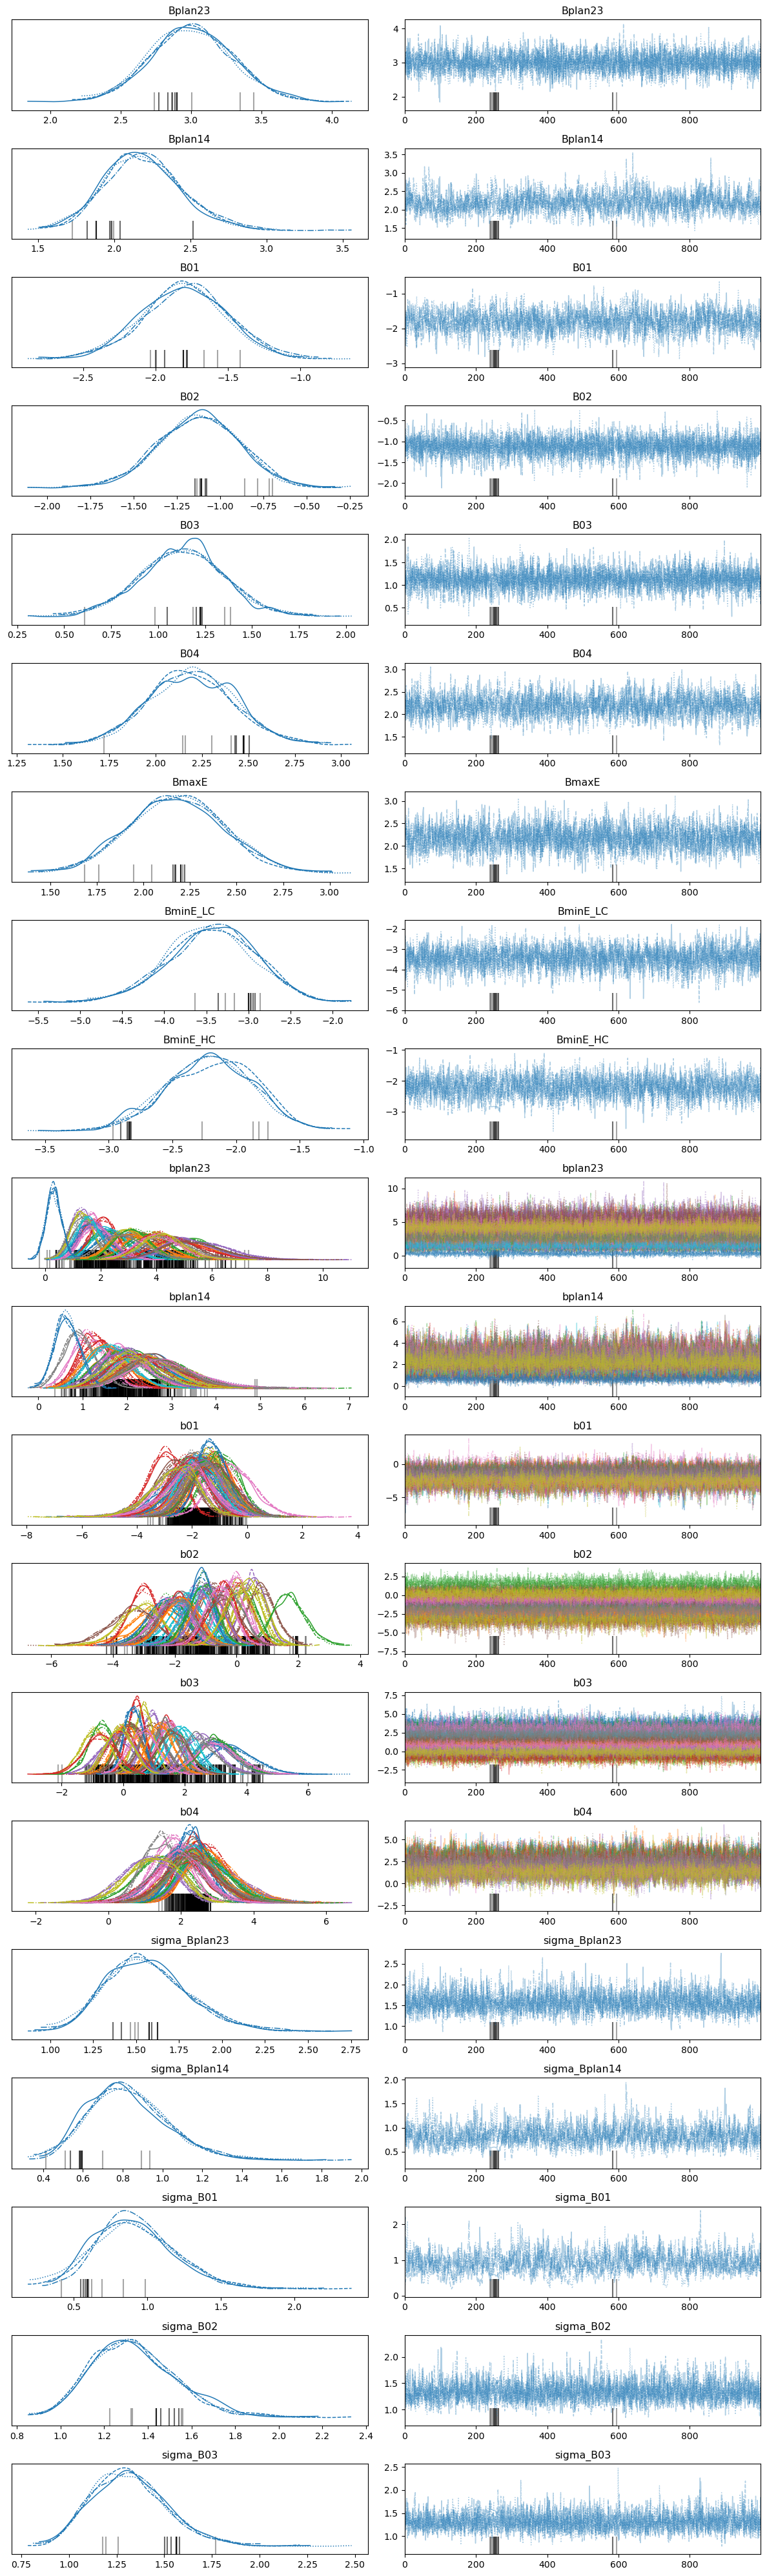

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Bplan23,3.004,0.292,2.455,3.553,0.004,0.005,4606.0,2658.0,1.00
Bplan14,2.190,0.257,1.702,2.677,0.009,0.005,750.0,1688.0,1.00
B01,-1.799,0.298,-2.386,-1.254,0.008,0.005,1249.0,1887.0,1.00
B02,-1.123,0.238,-1.552,-0.668,0.004,0.004,4226.0,2899.0,1.00
B03,1.128,0.226,0.668,1.524,0.003,0.004,5147.0,3043.0,1.00
...,...,...,...,...,...,...,...,...,...
sigma_Bplan14,0.828,0.202,0.471,1.211,0.008,0.004,683.0,1507.0,1.00
sigma_B01,0.911,0.279,0.400,1.438,0.012,0.006,524.0,528.0,1.01
sigma_B02,1.337,0.196,0.995,1.705,0.003,0.003,3254.0,3316.0,1.00
sigma_B03,1.319,0.197,0.963,1.681,0.003,0.003,3301.0,3214.0,1.00


In [6]:
with binomial_regression_model:
    idata = pm.sample(1000, tune=1000, target_accept=.9)
az.plot_trace(idata)
plt.tight_layout()
plt.show()
az.summary(idata)

As we can see, the results we obtain with this model are very similar to what is presented in the paper, indicating that we have implemented it correctly (small deviations are to be expected given the randomness associated with the sampling procedure). Now that we have established that the modeling works well, we can go ahead and simulate data based on our own design and decision values to test parameters recovery.

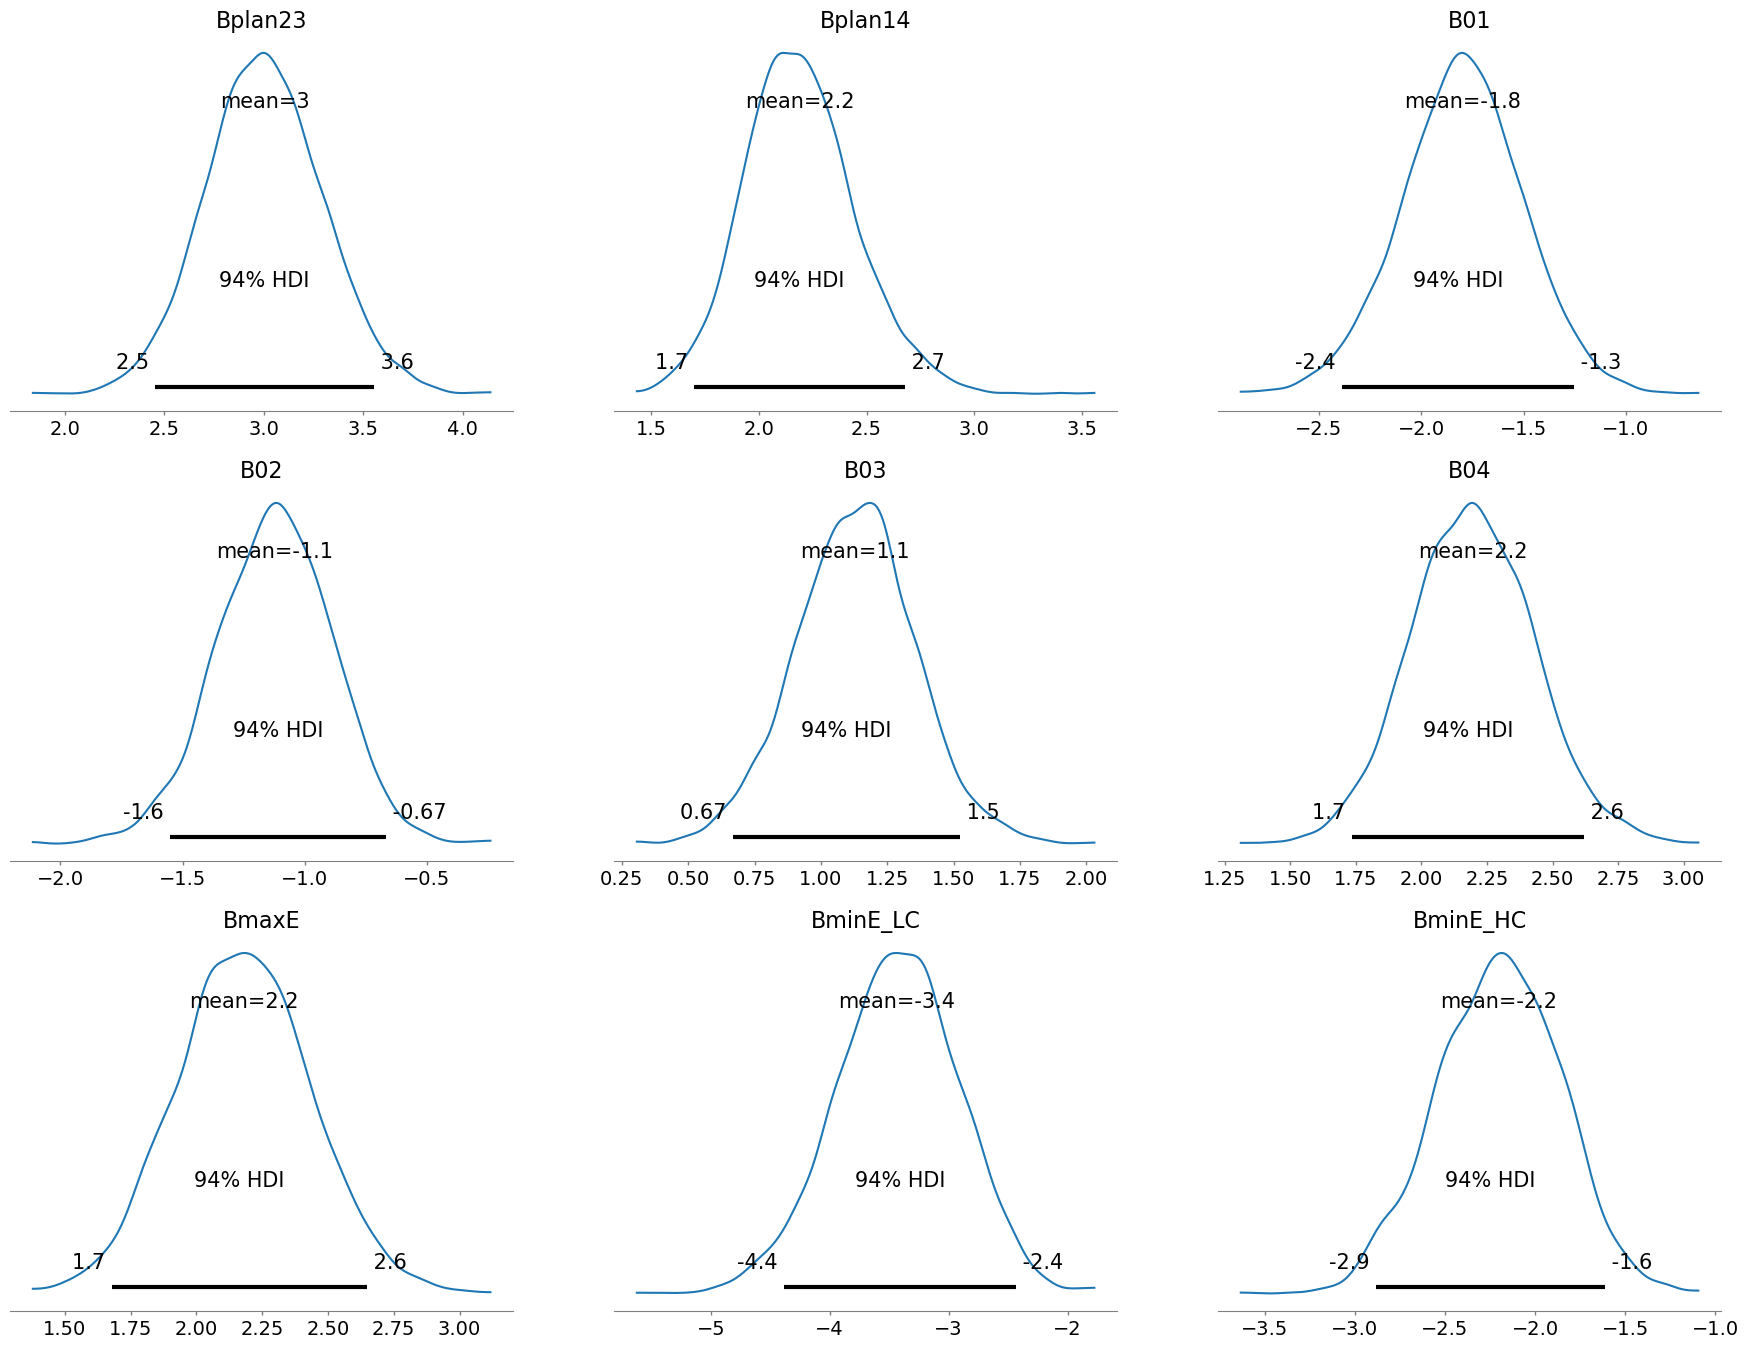

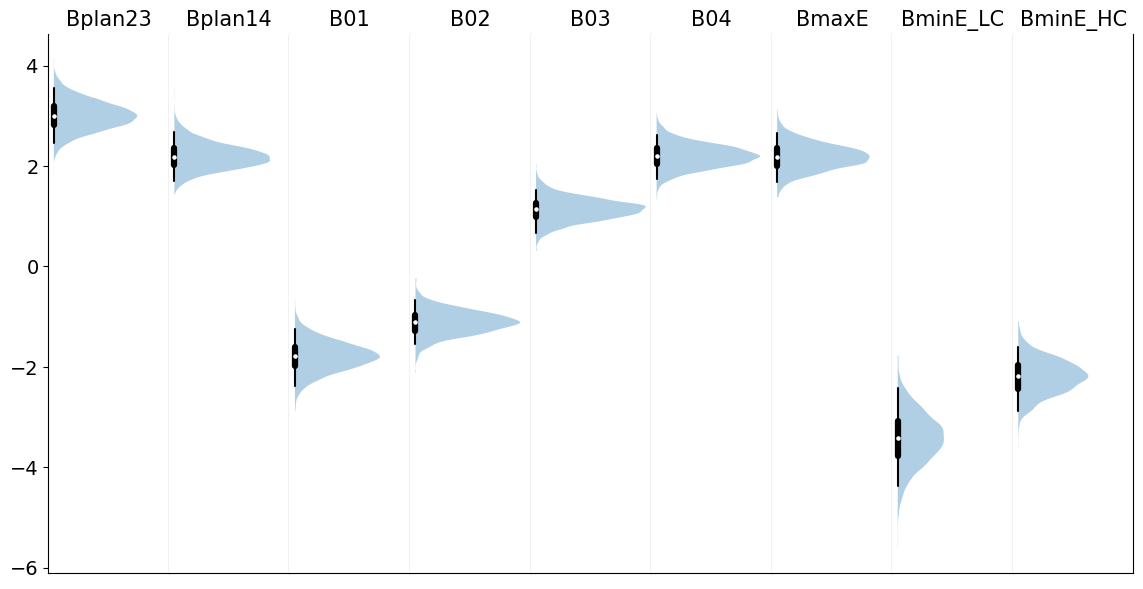

In [26]:
az.plot_posterior(idata, var_names=['Bplan23', 'Bplan14', 'B01', 'B02', 'B03', 'B04', 'BmaxE', 'BminE_LC', 'BminE_HC']);
axes = az.plot_violin(idata, var_names=['Bplan23', 'Bplan14', 'B01', 'B02', 'B03', 'B04', 'BmaxE', 'BminE_LC', 'BminE_HC'], 
                      side='right', grid=(1, 9), figsize=(14, 7)); #, kind='ridgeplot', combined=True, ridgeplot_truncate=False, ridgeplot_quantiles=[.25, .5, .75], ridgeplot_overlap=0.7, colors='white',figsize=(9, 7));
[ax.spines[['top']].set_visible(False) for ax in axes];
